<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/tf_ClassficationLocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download The Dataset

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz >> tmp.txt 
!rm  images/*.mat

The dataset contains around 37 category pet  with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. For this task we only use a classification between dogs and cats so we discard the other categories. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

# Basic Introduction 

So basically we create a convolutional neural network with two branches. The first branch is a binary classifier that classifies either dogs or cats. The second branch uses regression to extract the bounding box coordinates. The class scores will output two values $[y_1, y_2]$ which unscaled logits for the prediction regarding each class i.e either cat or dog. The regression branch will output four values $[xmin, ymin, xmax, ymax]$ where $(xmin, ymin)$ is the top left corner and $(xmax, ymax)$ is the bottom right corner of the bounding box. We assume that these values are scaled to the interval $[0, 1]$ which allows scaling the bounding box regardless of the size of the image 

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/LocalizationRegression2.png)

# Imports

We use tensorflow with eager execution. Hence, eager execution allows immediate evaluation of tensors without instintiating graph. 

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
import tensorflow.contrib.eager as tfe

In [0]:
tf.enable_eager_execution()

# Extract Annotations

So for each image path associate an array of the following format $[label, xmin, ymin, xmax, ymax]$ where the first index is the class i.e $\{0, 1\}$ and the rest is the bounding box prediction scaled in the region $[0, 1]$. 

In [0]:
import xml.etree.ElementTree
import os
from random import shuffle

#read the xml file which contains the bounding boxes
xmls = os.listdir('annotations/xmls')

#store the file names and the labels
files  = []
labels = []

#shuffle the files 
shuffle(xmls)

#iterate through all the annotations
for x in xmls:
  path = f'annotations/xmls/{x}'
  
  #the root of the xml file 
  root = xml.etree.ElementTree.parse(path).getroot()
  
  obj  = root.find('object')
  
  #bounding box values 
  bndx = obj.find('bndbox')
  xmin = bndx.find('xmin').text
  xmax = bndx.find('xmax').text
  ymin = bndx.find('ymin').text
  ymax = bndx.find('ymax').text

  #size of the original images 
  size = root.find('size')
  w = size.find('width').text
  h = size.find('height').text
  
  #extract the label 
  name = obj.find('name').text
  if name == 'dog':
    lbl = 1
  else:
    lbl = 0 
  
  #extract the filename 
  filename = root.find('filename').text
    
  #the annotations with bounding boxes rescaled 
  box = [lbl, int(xmin)/int(w), int(ymin)/int(h), int(xmax)/int(w), int(ymax)/int(h)]
  
  files.append(f'images/{filename}')
  labels.append(box)

#Create A Dataset

Here we use `tf.data` for manipulating the data and use them for training

In [0]:
#Decode and resize each image 
def parse_data(filename, label):
  
  image = tf.image.decode_jpeg(tf.read_file(filename), channels = 3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_images(image, [IMG_SIZE, IMG_SIZE])
  
  return image, label

In [0]:
#use tf.data to create a dataset  
def create_dataset(fs, ls):
  
  dataset = tf.data.Dataset.from_tensor_slices((fs, ls)).shuffle(len(fs) - 1)
  dataset = dataset.map(parse_data, num_parallel_calls = 4)
  dataset = dataset.batch(BATCH_SIZE)
                          
  return dataset

# Data Split

We create a 10% split for the test data to be used for validation 

In [0]:
N = len(files)
M = int(0.9 * N)

#split files for images 
train_files = files[:M]
test_files  = files[M:]

#split labels
train_labels = labels[:M]
test_labels =  labels[M:]

In [16]:
print('training', len(train_files))
print('testing' , len(test_files))

training 3317
testing 369


In [0]:
IMG_SIZE = 128
NUM_CLASSES = 2 
BATCH_SIZE = 32
class_names = ['cat', 'dog']

train_dataset = create_dataset(train_files, train_labels)
test_dataset = create_dataset(test_files, test_labels)

# Visualization 

In [0]:
def plot_annot(x, y):
  #convert to numpy 
  img   = x.numpy() 
  annot = y.numpy()
  
  #extract the label and its name 
  lbl   = annot[0].astype('int32')
  print(class_names[lbl])
  
  #rescale the bounding box and draw it 
  box = annot[1:]
  box = [int(IMG_SIZE * x) for x in box]
  img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (1., 0., 0.))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

dog


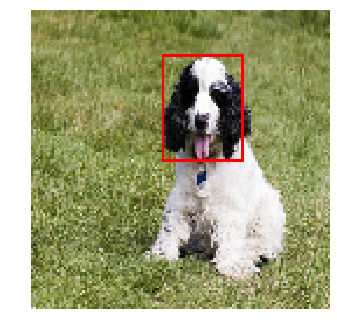

In [22]:
for x, y in train_dataset:
  plot_annot(x[0], y[0])
  break

# Create a model 

In [0]:
def conv_block(fs, x):
  conv  = Conv2D(fs, (3, 3), padding = 'same', activation = 'relu')(x)
  pool  = MaxPooling2D(pool_size = (2, 2))(conv)
  return pool

In [0]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))

block1 = conv_block(16, inp)
block2 = conv_block(32, block1)
block3 = conv_block(64, block2)
block4 = conv_block(128, block3)
block5 = conv_block(128, block4)
block6 = conv_block(128, block5)
flatten = Flatten()(block6)

#first branch for classification
branch1 = Dense(256, activation = 'relu')(flatten)
branch1 = Dropout(0.5)(branch1)
out1 = Dense(NUM_CLASSES)(branch1)

#second branch for bounding box regression 
branch2 = Dense(256, activation = 'relu')(flatten)
out2 = Dense(4, activation = 'sigmoid')(branch2)

#create a model with one input and two outputs 
model = tf.keras.models.Model(inputs = inp, outputs = [out1, out2])

Here, we evaluate the loss and the gradient of the loss. The `grad` function evaluates the gradient of the mode with respect to the parameters. 

The loss function on the other hand evaluates a decaying weighted sum between the prediction  error and the detection error as 

$$loss = d_{error} + p_w * p_{error}$$

where $p_w$ is a decaying parameter which penalizes the prediction error. When training the model I realized that most of the features learnt are related to classification so we need to teach the network to discard that and forces it to learn the regression after some time. Also, we use an `Adam` optimizer to update the parameters using the gradient function. 

In [0]:
#decay the loss of the accuracy
pred_weight = 0.9 

def loss(pred, y):
  global pred_weight 
  
  pred1, pred2 = pred 
  prediction_error = tf.losses.sparse_softmax_cross_entropy(tf.cast(y[:,0], tf.int32), logits = pred1)
  detection_error  = tf.losses.mean_squared_error(y[:, 1:], pred2)     
  
  
  return detection_error +  pred_weight * prediction_error
           
def grad(model, x, y):
  #record the gradient
  with tf.GradientTape() as tape:
    pred = model(x)
    value = loss(pred, y)
  #return the gradient of the loss function with respect to the model variables 
  return tape.gradient(value, model.variables)

optimizer = tf.train.AdamOptimizer()

Here we need to evaluate the metrics of the classification and the regression. For the classification we use a simple function to calculate the accuracy. For the bounding box prediction we IoU which evaluates the intersection over union between the predicted value and true value of the box. 

In [0]:
def acc(pred, y):
  #prediction
  yhat, _ = pred
  
  #get the labels of the predicted values 
  yhat = tf.argmax(yhat, 1).numpy()
  
  #get the labels of the true values
  y    = y[:,0].numpy()
  return np.sum(y == yhat)/len(y)

def mean_iou(pred, y):
  boxA = y[:, 1:]  
  _, boxB = pred
  
  
  #evaluate the intersection points 
  xA = tf.maximum(boxA[:, 0], boxB[:, 0])
  yA = tf.maximum(boxA[:, 1], boxB[:, 1])
  xB = tf.minimum(boxA[:, 2], boxB[:, 2])
  yB = tf.minimum(boxA[:, 3], boxB[:, 3])

  # compute the area of intersection rectangle
  interArea = tf.maximum(0, xB - xA + 1) * tf.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  #compute the union 
  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(interArea / unionArea)

In [0]:
epochs = 20

#initialize the history to record the metrics 
train_loss_history = tfe.metrics.Mean('train_loss')
train_acc_history  = tfe.metrics.Mean('train_acc')
train_iou_history  = tfe.metrics.Mean('train_iou')

test_loss_history = tfe.metrics.Mean('test_loss')
test_acc_history  = tfe.metrics.Mean('test_acc')
test_iou_history  = tfe.metrics.Mean('test_iou')

In [51]:
for i in range(0, epochs):
  
  for x, y in train_dataset:
    pred = model(x)
    grads = grad(model, x, y)

    #update the paramters of the model 
    optimizer.apply_gradients(zip(grads, model.variables), global_step = tf.train.get_or_create_global_step())

    #record the metrics of the current batch 
    loss_value = loss(pred, y)
    acc_value  = acc(pred,y)
    iou_value = mean_iou(pred, y)
    
    #calcualte the metrics of the current batch
    train_loss_history(loss_value)
    train_acc_history(acc_value)
    train_iou_history(iou_value)
  
  #reduce the prediction weight
  if i % 2 == 0:
    pred_weight = pred_weight ** 2 
  
  #loop over the test dataset 
  for x, y in test_dataset:
    pred = model(x)
    
    #calcualte the metrics of the current batch 
    loss_value = loss(pred, y)
    acc_value  = acc(pred,y)
    iou_value = mean_iou(pred, y)
    
    #record the values of the metrics 
    test_loss_history(loss_value)
    test_acc_history(acc_value)
    test_iou_history(iou_value)
    
  #print out the results 
  print("epoch: [{0:d}/{1:d}], Train: [loss: {2:0.4f}, acc: {3:0.2f}, iou: {4:0.2f}], Test: [loss: {5:0.4f}, acc: {6:0.2f}, iou:{7:0.2f}]".
       format(i, epochs, train_loss_history.result(),  train_acc_history.result(), train_iou_history.result(),
             test_loss_history.result(),  test_acc_history.result(), test_iou_history.result()))
  
  #clear the history after each epoch 
  train_acc_history.init_variables()
  train_loss_history.init_variables()
  train_iou_history.init_variables()
  
  test_acc_history.init_variables()
  test_loss_history.init_variables()
  test_iou_history.init_variables()

epoch: [0/20], Train: [loss: 0.5939, acc: 0.67, iou: 0.69], Test: [loss: 0.5268, acc: 0.68, iou:0.72]
epoch: [1/20], Train: [loss: 0.5138, acc: 0.68, iou: 0.73], Test: [loss: 0.5320, acc: 0.69, iou:0.72]
epoch: [2/20], Train: [loss: 0.5032, acc: 0.68, iou: 0.74], Test: [loss: 0.4013, acc: 0.69, iou:0.73]
epoch: [3/20], Train: [loss: 0.3936, acc: 0.71, iou: 0.74], Test: [loss: 0.4142, acc: 0.66, iou:0.73]
epoch: [4/20], Train: [loss: 0.3711, acc: 0.73, iou: 0.74], Test: [loss: 0.2420, acc: 0.76, iou:0.74]
epoch: [5/20], Train: [loss: 0.2245, acc: 0.77, iou: 0.75], Test: [loss: 0.2338, acc: 0.76, iou:0.74]
epoch: [6/20], Train: [loss: 0.2103, acc: 0.79, iou: 0.75], Test: [loss: 0.1060, acc: 0.81, iou:0.74]
epoch: [7/20], Train: [loss: 0.0826, acc: 0.85, iou: 0.76], Test: [loss: 0.1024, acc: 0.81, iou:0.74]
epoch: [8/20], Train: [loss: 0.0673, acc: 0.89, iou: 0.76], Test: [loss: 0.0342, acc: 0.82, iou:0.75]
epoch: [9/20], Train: [loss: 0.0215, acc: 0.94, iou: 0.77], Test: [loss: 0.0333, a

# Visualization 

In [0]:
#get the conficence value and the higest predicted value 
def get_confidence(logits):
  exp = tf.exp(logits)
  softmax = exp/np.sum(exp)
  
  max_index =  tf.argmax(logits)
  confidence=  softmax[max_index]
  return max_index.numpy() , confidence.numpy()

#visualize the predicted bounding box
def plot_annot(img_id):
  
  raw = cv2.imread(img_id)[:,:,::-1]
  
  h, w = (1024, 1024)
  
  img = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype('float32')
  img = np.expand_dims(img, 0)/255. 
  
  
  pred1, pred2 = model(img)
  
  box = pred2.numpy()[0] 
  box = [int(box[0]*w), int(box[1]*h), int(box[2]*w), int(box[3]*h)]

  label, confidence = get_confidence(pred1[0])
  
  font = cv2.FONT_HERSHEY_SIMPLEX
  
  text = f'{class_names[label]}: {int(confidence * 100)} %'
  text_len = len(text)
  
  weight = 2 
  
  if label:
    color = (0, 0, 255)
  else:
    color = (0, 255, 0)
    
  raw = cv2.resize(raw, (w, h))
  raw = cv2.rectangle(raw, (box[0], box[1]), (box[2], box[3]), color, 2*weight + 1)
  raw = cv2.rectangle(raw, (box[0] - weight, box[1] - 12 * weight), (box[0] + text_len * 9 * weight, box[1]), color, cv2.FILLED)
  raw = cv2.putText(raw, f'{text}',(box[0], box[1]), font, 1,(255,255,255), weight , cv2.LINE_AA)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(raw)

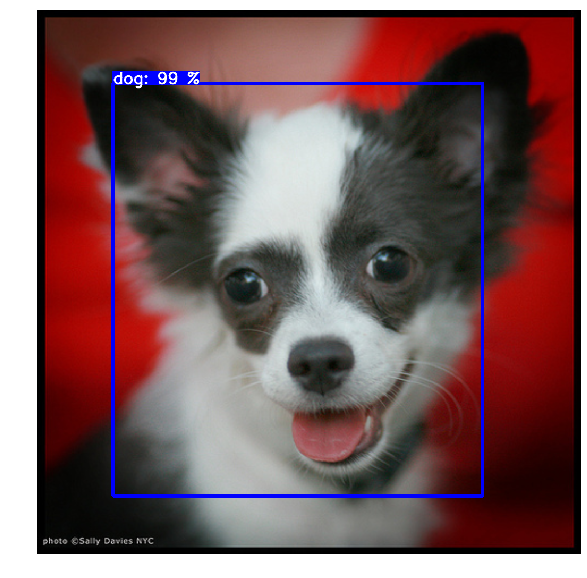

In [67]:
img_id = np.random.choice(test_files)

plot_annot(img_id)